[*********************100%***********************]  1 of 1 completed
c:\Users\edgar\miniconda3\envs\primary\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Model Performance:
LR:  MSE=0.000103, Acc=54.69%
XGB: MSE=0.000112, Acc=51.56%
RNN: MSE=0.000104, Acc=56.64%


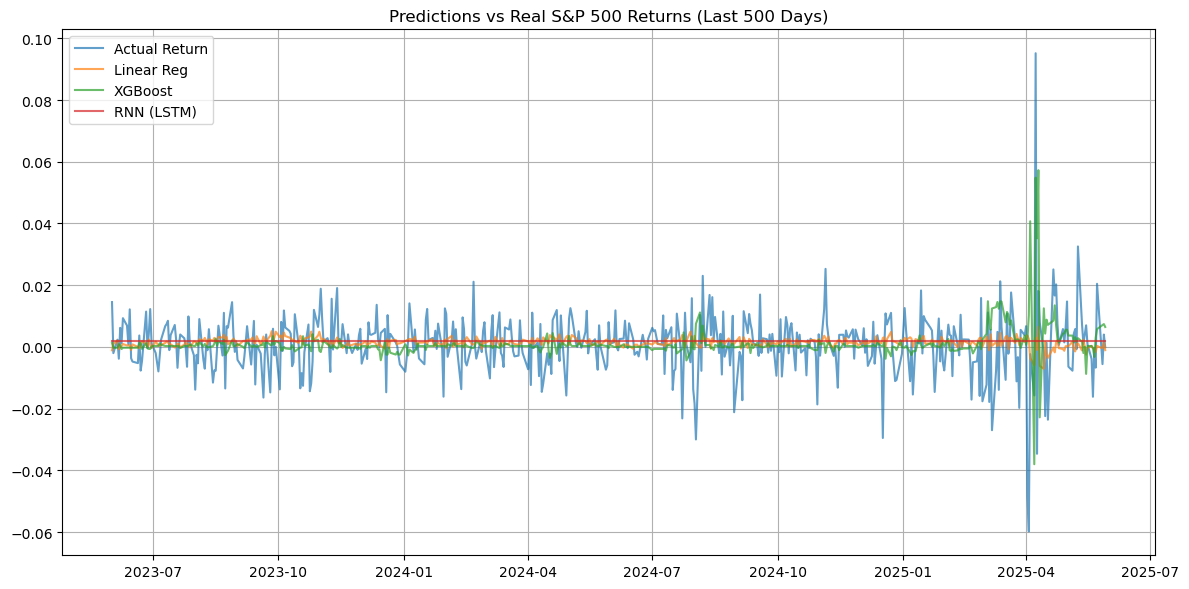

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import ta
from pandas_datareader import data as pdr_fred
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import LSTM, Dense

# 1. Download S&P 500 data
sp500 = yf.download('^GSPC', start='2015-01-01', end='2025-06-01', auto_adjust=True)

if isinstance(sp500.columns, pd.MultiIndex):
    sp500.columns = sp500.columns.get_level_values(0)

# 2. Get macro data from FRED
start = sp500.index.min()
end = sp500.index.max()
fred_codes = {
    'GDP': 'GDP',                 # Quarterly GDP
    'UNRATE': 'UNRATE',          # Monthly Unemployment Rate
    'UMCSENT': 'UMCSENT'         # Michigan Consumer Sentiment
}
macro = pdr_fred.DataReader(list(fred_codes.values()), 'fred', start, end)
macro = macro.rename(columns={v: k for k, v in fred_codes.items()})
macro = macro.resample('D').ffill()  # Align daily, forward-fill
macro = macro.reindex(sp500.index).ffill().dropna()

# 3. Feature engineering
df = sp500.copy()
df['Return'] = df['Close'].pct_change()
df['Lag1'] = df['Return'].shift(1)
df['Lag2'] = df['Return'].shift(2)
df['Lag3'] = df['Return'].shift(3)

# Extract as Series (1D)
close_series = df['Close'].squeeze()
high_series = df['High'].squeeze()
low_series = df['Low'].squeeze()

# Technical indicators
df['RSI'] = ta.momentum.RSIIndicator(close=close_series, window=14).rsi()
df['MACD'] = ta.trend.MACD(close=close_series).macd_diff()
df['ATR'] = ta.volatility.AverageTrueRange(high=high_series, low=low_series, close=close_series).average_true_range()
df['ADX'] = ta.trend.ADXIndicator(high=high_series, low=low_series, close=close_series).adx()


# Add macro features
df = df.join(macro)
df = df.dropna()

# 4. Prepare features and target
features = ['Lag1','Lag2','Lag3','RSI','MACD','ATR','ADX','GDP','UNRATE','UMCSENT']
X = df[features]
y = df['Return'].shift(-1).loc[X.index]
X = X.iloc[:-1]
y = y.iloc[:-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# 5. Train models
lr = LinearRegression().fit(X_train, y_train)
xgb = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42).fit(X_train, y_train)

# Prepare RNN input
def reshape_for_rnn(arr):
    return arr.values.reshape((arr.shape[0], 1, arr.shape[1]))

rnn = Sequential([
    LSTM(50, input_shape=(1, len(features))),
    Dense(1)
])
rnn.compile(loss='mse', optimizer='adam')
rnn.fit(reshape_for_rnn(X_train), y_train, epochs=10, verbose=0)

# 6. Predictions
pred_lr = lr.predict(X_test)
pred_xgb = xgb.predict(X_test)
pred_rnn = rnn.predict(reshape_for_rnn(X_test)).flatten()

# 7. Evaluation
mse_lr = mean_squared_error(y_test, pred_lr)
mse_xgb = mean_squared_error(y_test, pred_xgb)
mse_rnn = mean_squared_error(y_test, pred_rnn)

acc_lr = accuracy_score(y_test > 0, pred_lr > 0)
acc_xgb = accuracy_score(y_test > 0, pred_xgb > 0)
acc_rnn = accuracy_score(y_test > 0, pred_rnn > 0)

print("Model Performance:")
print(f"LR:  MSE={mse_lr:.6f}, Acc={acc_lr:.2%}")
print(f"XGB: MSE={mse_xgb:.6f}, Acc={acc_xgb:.2%}")
print(f"RNN: MSE={mse_rnn:.6f}, Acc={acc_rnn:.2%}")

# 8. Plot actual vs predicted
# Limit to last 500 points for clearer plotting
window = 500
index = y_test.index[-window:]

plt.figure(figsize=(12, 6))
plt.plot(index, y_test[-window:], label='Actual Return', alpha=0.7)
plt.plot(index, pred_lr[-window:], label='Linear Reg', alpha=0.7)
plt.plot(index, pred_xgb[-window:], label='XGBoost', alpha=0.7)
plt.plot(index, pred_rnn[-window:], label='RNN (LSTM)', alpha=0.7)
plt.legend()
plt.title("Predictions vs Real S&P 500 Returns (Last 500 Days)")
plt.grid(True)
plt.tight_layout()
plt.show()

